# Si execution sur Colab

In [ ]:
from google.colab import files

# Ouvrir une fenêtre de sélection pour importer le fichier
uploaded = files.upload()

In [ ]:
import zipfile

# Décompresser le fichier data.zip dans le répertoire /content/data
with zipfile.ZipFile("data.zip", "r") as zip_ref:
    zip_ref.extractall("data")

# Vérifier la structure des fichiers décompressés
import os
for root, dirs, files in os.walk("data"):
    print(f"Chemin : {root}")
    print(f"Dossiers : {dirs}")
    print(f"Fichiers : {files[:5]}")  # Limiter l'affichage à 5 fichiers par dossier

Dans les dictionnaire de chemin il faut ajouter au debut /content/

# Self supervised learning for anomaly detection

# Librairy imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import roc_curve, auc

import os
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt

#from google.colab import files  # Pour télécharger les modèles depuis Colab

/opt/anaconda3/envs/torch/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


# Data exploration

In [3]:
class ImageDataExplorer:
    def __init__(self, data_dirs):
        """
        Initialise l'explorateur de données avec les chemins des répertoires des images.

        Args:
            data_dirs (dict): Dictionnaire {catégorie: chemin_du_dossier}.
        """
        self.data_dirs = data_dirs
        self.transform = transforms.ToTensor()
        self.pixel_stats = {}

    def inspect_image_sizes(self, num_samples=10):
        """
        Inspecte les tailles d'images pour chaque catégorie.

        Args:
            num_samples (int): Nombre d'images à inspecter par catégorie.
        """
        for category, folder in self.data_dirs.items():
            image_sizes = []
            for i, img_name in enumerate(os.listdir(folder)):
                if i >= num_samples:
                    break
                img_path = os.path.join(folder, img_name)
                with Image.open(img_path) as img:
                    image_sizes.append(img.size)  # (width, height)

            print(f"Exemples de tailles d'images pour {category} : {image_sizes}")
        print("\n")

    def compute_pixel_stats(self):
        """
        Calcule les moyennes et écarts-types des valeurs de pixels par canal (R, G, B).
        """
        pixel_sum = np.zeros(3)  # Pour la somme des pixels par canal (R, G, B)
        pixel_square_sum = np.zeros(3)  # Pour la somme des carrés des pixels par canal
        n_pixels = 0

        for category, folder in self.data_dirs.items():
            pixel_values = []
            for img_name in os.listdir(folder):
                img_path = os.path.join(folder, img_name)
                with Image.open(img_path) as img:
                    img_tensor = self.transform(img)
                    n_pixels += img_tensor.size(1) * img_tensor.size(2)  # Ajoute le nombre total de pixels par canal
                    pixel_sum += img_tensor.sum(dim=(1, 2)).numpy()  # Somme des pixels par canal
                    pixel_square_sum += (img_tensor ** 2).sum(dim=(1, 2)).numpy()  # Somme des carrés des pixels par canal 

            # Moyenne et écart-type par canal
            mean = pixel_sum / n_pixels
            std = np.sqrt(pixel_square_sum / n_pixels - mean ** 2)

            # Stocker les statistiques dans le dictionnaire
            self.pixel_stats[category] = {"mean": mean, "std": std}

            print(f"Pour {category} :")
            print(f"Moyennes par canal (R, G, B) : {mean}")
            print(f"Écarts-types par canal (R, G, B) : {std}")
            print("\n")


    def get_pixel_stats(self):
        """
        Returns:
            dict: Dictionnaire contenant les moyennes et écarts-types par catégorie.
        """
        return self.pixel_stats
    

    def visualize_resized_images(self, img_sizes=(32, 64, 128, 256), num_samples=1):
        """
        Visualise les redimensionnements d'images à différentes tailles.

        Args:
            img_sizes (tuple): Tailles des redimensionnements à tester.
            num_samples (int): Nombre d'images à afficher par catégorie.
        """
        resize_transforms = {
            size: transforms.Compose([transforms.Resize((size, size)), transforms.ToTensor()])
            for size in img_sizes
        }

        for category, folder in self.data_dirs.items():
            for i, img_name in enumerate(os.listdir(folder)):
                if i >= num_samples:
                    break
                img_path = os.path.join(folder, img_name)
                with Image.open(img_path) as img:
                    resized_images = {size: transform(img).permute(1, 2, 0) for size, transform in resize_transforms.items()}

                # Tracer les images redimensionnées
                fig, axs = plt.subplots(1, len(img_sizes), figsize=(15, 4))
                for ax, (size, resized_img) in zip(axs, resized_images.items()):
                    ax.imshow(resized_img)
                    ax.set_title(f"{size}x{size}")
                plt.suptitle(f"Redimensionnement des images de {category}")
                plt.show()


Exemples de tailles d'images pour bottle : [(900, 900), (900, 900), (900, 900), (900, 900), (900, 900), (900, 900), (900, 900), (900, 900), (900, 900), (900, 900)]
Exemples de tailles d'images pour capsule : [(1000, 1000), (1000, 1000), (1000, 1000), (1000, 1000), (1000, 1000), (1000, 1000), (1000, 1000), (1000, 1000), (1000, 1000), (1000, 1000)]
Exemples de tailles d'images pour hazelnut : [(1024, 1024), (1024, 1024), (1024, 1024), (1024, 1024), (1024, 1024), (1024, 1024), (1024, 1024), (1024, 1024), (1024, 1024), (1024, 1024)]
Exemples de tailles d'images pour toothbrush : [(1024, 1024), (1024, 1024), (1024, 1024), (1024, 1024), (1024, 1024), (1024, 1024), (1024, 1024), (1024, 1024), (1024, 1024), (1024, 1024)]
Exemples de tailles d'images pour engine_wiring : [(400, 400), (400, 400), (400, 400), (400, 400), (400, 400), (400, 400), (400, 400), (400, 400), (400, 400), (400, 400)]


Pour bottle :
Moyennes par canal (R, G, B) : [0.53541012 0.53168199 0.54795864]
Écarts-types par canal (

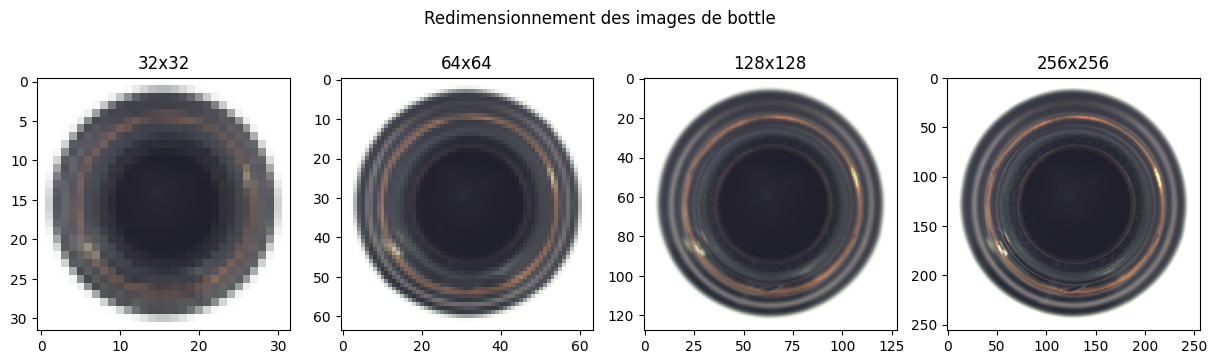

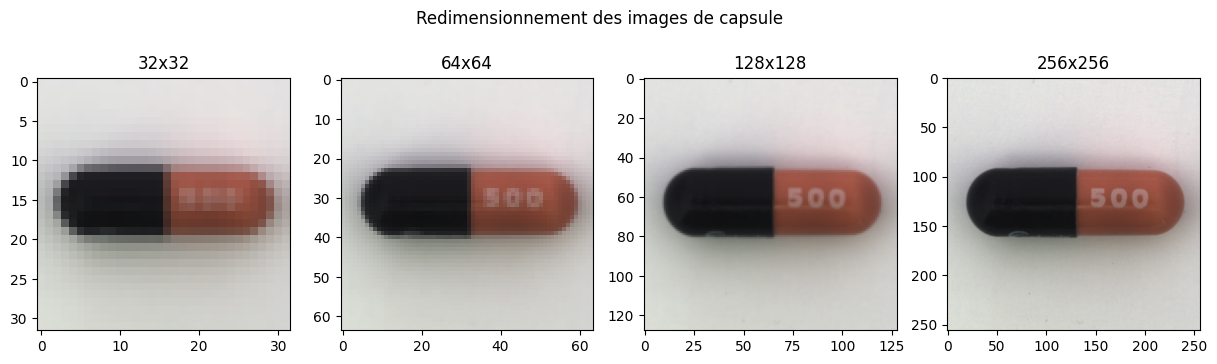

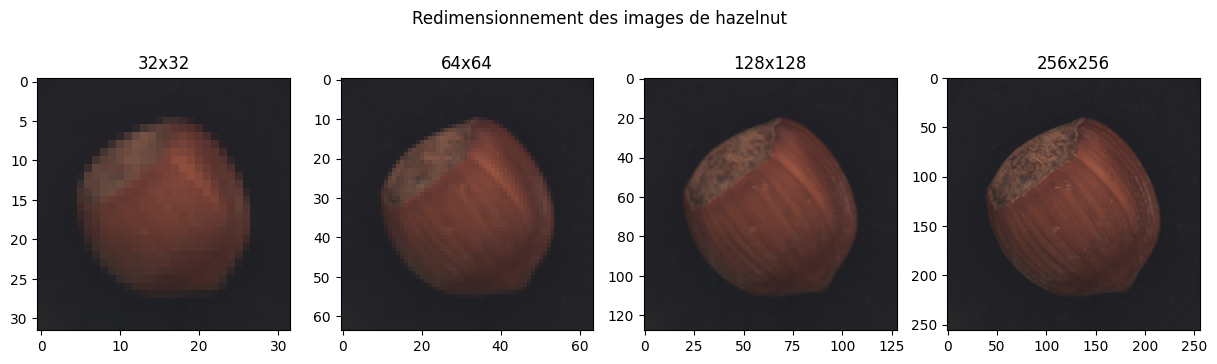

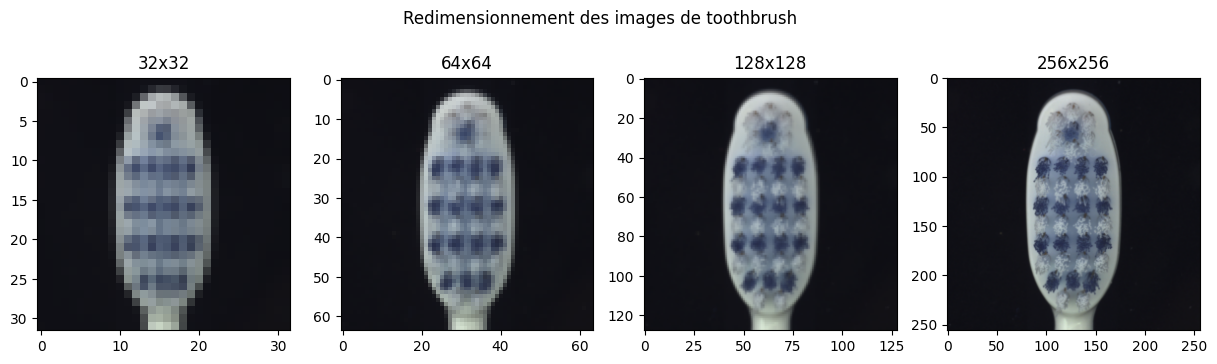

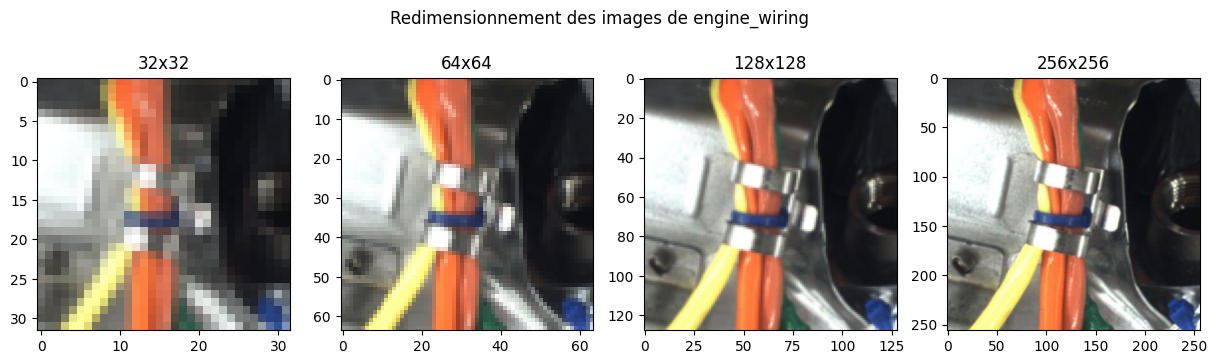

In [4]:
# Dossier racine des données
data_dir_dict = {
    'bottle': 'data/bottle/train/good',
    'capsule': 'data/capsule/train/good',
    'hazelnut': 'data/hazelnut/train/good',
    'toothbrush': 'data/toothbrush/train/good',
    'engine_wiring': 'data/engine_wiring/train/good'
}

explorer = ImageDataExplorer(data_dirs=data_dir_dict)

# Inspecter les tailles des images
explorer.inspect_image_sizes(num_samples=10)

# Calculer les statistiques des pixels
explorer.compute_pixel_stats()

# On stocke les statistiques des pixels pour la normalisation
pixel_stats = explorer.get_pixel_stats()

# Visualiser les différents redimensionnements
explorer.visualize_resized_images(img_sizes=(32, 64, 128, 256), num_samples=1)

# Data preparation

In [5]:
class CategoryDataset(Dataset):
    def __init__(self, root_dir, mean, std, mode="train"):
        """
        Classe pour charger un dataset d'une catégorie spécifique avec normalisation.

        Args:
            root_dir (str): Racine des données pour une catégorie spécifique.
            mean (list): Moyenne par canal (R, G, B).
            std (list): Écart-type par canal (R, G, B).
            mode (str): "train" ou "test".
        """
        self.root_dir = os.path.join(root_dir, mode)
        self.image_paths = []
        self.labels = []  # 0 = normal, 1 = anomalie

        # Transformation avec redimensionnement et normalisation
        self.transform = transforms.Compose([
            #transforms.Resize((128, 128)),
            transforms.Resize((256,256)),
            transforms.ToTensor(),
            transforms.Normalize(mean=mean, std=std)
        ])

        # Charger les chemins d'images et les labels
        if mode == "train":
            normal_dir = os.path.join(self.root_dir, "good")
            self.image_paths += [os.path.join(normal_dir, f) for f in os.listdir(normal_dir)]
            self.labels += [0] * len(self.image_paths)
        elif mode == "test":
            for defect_type in os.listdir(self.root_dir):
                defect_dir = os.path.join(self.root_dir, defect_type)
                self.image_paths += [os.path.join(defect_dir, f) for f in os.listdir(defect_dir)]
                self.labels += [0 if defect_type == "good" else 1] * len(os.listdir(defect_dir))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

In [6]:
def prepare_datasets(data_dir_dict, pixel_stats, mode="train"):
    """
    Crée les datasets pour chaque catégorie en utilisant les statistiques calculées.

    Args:
        data_dir_dict (dict): Dictionnaire {catégorie: chemin_du_dossier}.
        pixel_stats (dict): Dictionnaire {catégorie: {"mean": [...], "std": [...]}}.
        mode (str): "train" ou "test".

    Returns:
        dict: Dictionnaire {catégorie: dataset}.
    """
    datasets_dict = {}

    for category, folder in data_dir_dict.items():
        mean = pixel_stats[category]["mean"]
        std = pixel_stats[category]["std"]

        # Créer le dataset pour la catégorie
        datasets_dict[category] = CategoryDataset(
            root_dir=folder,
            mean=mean,
            std=std,
            mode=mode
        )

    return datasets_dict


In [7]:
# On verifie qu'on a bien nos stats

print("Statistiques des pixels :")
for category, stats in pixel_stats.items():
    print(f"{category} : Moyenne = {stats['mean']}, Écart-type = {stats['std']}")


Statistiques des pixels :
bottle : Moyenne = [0.53541012 0.53168199 0.54795864], Écart-type = [0.36676049 0.36667316 0.34991978]
capsule : Moyenne = [0.62641897 0.60788297 0.6077917 ], Écart-type = [0.31168132 0.31775514 0.30712102]
hazelnut : Moyenne = [0.42798804 0.3865043  0.38363421], Écart-type = [0.31494227 0.31383207 0.30733228]
toothbrush : Moyenne = [0.41128353 0.37180342 0.36970357], Écart-type = [0.31515439 0.31211631 0.30463895]
engine_wiring : Moyenne = [0.4155514  0.37774341 0.3734649 ], Écart-type = [0.31693172 0.31385003 0.3048015 ]


In [8]:
data_dir_dict = {
    'bottle': 'data/bottle',
    'capsule': 'data/capsule',
    'hazelnut': 'data/hazelnut',
    'toothbrush': 'data/toothbrush',
    'engine_wiring': 'data/engine_wiring'
}

# Créer les datasets
train_datasets_dict = prepare_datasets(data_dir_dict, pixel_stats, mode="train")
test_datasets_dict = prepare_datasets(data_dir_dict, pixel_stats, mode="test")

# Vérification
print(f"Datasets de train créés pour les catégories : {list(train_datasets_dict.keys())}")
print(f"Datasets de test créés pour les catégories : {list(test_datasets_dict.keys())}")


Datasets de train créés pour les catégories : ['bottle', 'capsule', 'hazelnut', 'toothbrush', 'engine_wiring']
Datasets de test créés pour les catégories : ['bottle', 'capsule', 'hazelnut', 'toothbrush', 'engine_wiring']


In [9]:
batch_size = 32

# On crée les loaders

train_bottle_loader = DataLoader(train_datasets_dict['bottle'], batch_size=batch_size, shuffle=True)
test_bottle_loader = DataLoader(test_datasets_dict['bottle'], batch_size=batch_size, shuffle=False)

train_capsule_loader = DataLoader(train_datasets_dict['capsule'], batch_size=batch_size, shuffle=True)
test_capsule_loader = DataLoader(test_datasets_dict['capsule'], batch_size=batch_size, shuffle=False)

train_hazelnut_loader = DataLoader(train_datasets_dict['hazelnut'], batch_size=batch_size, shuffle=True)
test_hazelnut_loader = DataLoader(test_datasets_dict['hazelnut'], batch_size=batch_size, shuffle=False)

train_toothbrush_loader = DataLoader(train_datasets_dict['toothbrush'], batch_size=batch_size, shuffle=True)
test_toothbrush_loader = DataLoader(test_datasets_dict['toothbrush'], batch_size=batch_size, shuffle=False)

train_engine_wiring_loader = DataLoader(train_datasets_dict['engine_wiring'], batch_size=batch_size, shuffle=True)
test_engine_wiring_loader = DataLoader(test_datasets_dict['engine_wiring'], batch_size=batch_size, shuffle=False)


# On vérifie un batch
images, labels = next(iter(test_bottle_loader))
print(f"Taille du batch : {images.shape}, Labels : {labels}")


Taille du batch : torch.Size([32, 3, 256, 256]), Labels : tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1])


In [10]:
# On vérifie qu'on a bien les données good et défectueuses dans les test_loader
total_good = sum(1 for label in test_engine_wiring_loader.dataset.labels if label == 0)
total_defective = sum(1 for label in test_engine_wiring_loader.dataset.labels if label == 1)
print(f"Total images normales : {total_good}, Total images défectueuses : {total_defective}")


Total images normales : 285, Total images défectueuses : 322


In [11]:
# Dictionnaire des DataLoaders existants
data_loaders_dict = {
    'bottle': {
        'train_loader': train_bottle_loader,
        'test_loader': test_bottle_loader
    },
    'capsule': {
        'train_loader': train_capsule_loader,
        'test_loader': test_capsule_loader
    },
    'hazelnut': {
        'train_loader': train_hazelnut_loader,
        'test_loader': test_hazelnut_loader
    },
    'toothbrush': {
        'train_loader': train_toothbrush_loader,
        'test_loader': test_toothbrush_loader
    },
    'engine_wiring': {
        'train_loader': train_engine_wiring_loader,
        'test_loader': test_engine_wiring_loader
    }
}

# On reproduit le TP SSL sur nos données comme premier test

## Architecture partagée

In [ ]:
# Encoder architecture
class Encoder(nn.Module):
    def __init__(self, in_channels=3, latent_dim=256):
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=in_channels,out_channels=64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=64,out_channels=128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=128,out_channels=latent_dim, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
        )
    def forward(self, x):
        return self.encoder(x)



# Decoder architecture
class Decoder(nn.Module):
    def __init__(self, out_channels=3, latent_dim=256):
        super(Decoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=latent_dim, out_channels=128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=64, out_channels=out_channels, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
        )
    def forward(self, x):
        return self.decoder(x)

## Fonction d'entrainement

In [20]:
def train_ssl_model(model, train_loader, test_loader, criterion, optimizer, device=device, epochs=10):

    train_losses = []   
    val_losses = []

    for epoch in range(epochs):
        model.to(device)
        model.train()
        total_train_loss = 0
        #t=tqdm(train_loader)
        for images, _ in train_loader: #t
            images = images.to(device)
            optimizer.zero_grad()
            output, _ = model(images)
            loss = criterion(output, images)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for images, _ in test_loader:
                images = images.to(device)
                output, _ = model(images)
                val_loss = criterion(output, images)
                total_val_loss += val_loss.item()

        avg_val_loss = total_val_loss / len(test_loader)
        val_losses.append(avg_val_loss)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Avg Val Loss: {avg_val_loss:.4f}")

    # Tracer les pertes d'entraînement et de validation
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, epochs+1), train_losses, label='Train Loss', color='blue')
    plt.plot(range(1, epochs+1), val_losses, label='Val Loss', color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss over Epochs')
    plt.legend()
    plt.grid()
    plt.show()
    
    return model.encoder

## Fonction d'evaluation

In [19]:
def evaluate_ssl_model(model, test_loader, criterion=nn.MSELoss(reduction="none"), device="cuda"):
    """
    Évalue un modèle SSL sur les données de test et retourne l'AUROC.

    Args:
        model (nn.Module): Modèle SSL entraîné.
        test_loader (DataLoader): DataLoader pour les données de test.
        criterion (callable): Fonction de perte utilisée pour calculer le score d'anomalie.
        device (str): Périphérique pour l'évaluation.

    Returns:
        float: AUROC pour le modèle sur les données de test.
    """
    model.to(device)
    model.eval()

    anomaly_scores = []
    true_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)

            # Calcul de la sortie du modèle
            outputs, _ = model(images)

            # Calcul de la perte entre l'image reconstruite et l'image originale
            loss = criterion(outputs, images)  # Perte par pixel
            per_image_loss = loss.mean(dim=(1, 2, 3))  # Moyenne spatiale pour chaque image

            anomaly_scores.extend(per_image_loss.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    # Calcul des métriques ROC
    fpr, tpr, _ = roc_curve(true_labels, anomaly_scores)
    roc_auc = auc(fpr, tpr)

    # Traçage de la courbe ROC
    plt.figure()
    plt.plot(fpr, tpr, label=f"ROC curve (area = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.show()

    return roc_auc



## Pretext : Colorization

In [ ]:
class ColorizationModel(nn.Module):
    def __init__(self, latent_dim=256):
        super(ColorizationModel, self).__init__()
        self.encoder = Encoder(latent_dim=latent_dim, in_channels=1)  # Input grayscale
        self.decoder = Decoder(latent_dim=latent_dim, out_channels=3)  # Predict RGB

    def forward(self, x):
        grayscale_x = transforms.Grayscale()(x)  # Convert RGB to Grayscale
        z = self.encoder(grayscale_x)
        return self.decoder(z), grayscale_x

## Pretext : Inpainting

In [ ]:
class InpaintingModel(nn.Module):
    def __init__(self, latent_dim=256, mask_size=8):
        super(InpaintingModel, self).__init__()
        self.encoder = Encoder(latent_dim=latent_dim)
        self.decoder = Decoder(latent_dim=latent_dim)
        self.mask_size = mask_size

    def forward(self, x):
        x_masked = self.apply_mask(x)
        z = self.encoder(x_masked)
        return self.decoder(z), x_masked
    
    def apply_mask(self, x):
        masked_x = x.clone()

        for i in range(masked_x.size(0)):
            ul_x = np.random.randint(0, x.size(2) - self.mask_size + 1)
            ul_y = np.random.randint(0, x.size(3) - self.mask_size + 1)
            masked_x[i, :, ul_x:ul_x+self.mask_size, ul_y:ul_y+self.mask_size] = 0

        return masked_x

## Pretext : Masked Autoencoder

In [ ]:
class MaskedAutoencoderModel(nn.Module):
    def __init__(self, latent_dim=256, mask_ratio=1/16):
        super(MaskedAutoencoderModel, self).__init__()
        self.encoder = Encoder(latent_dim=latent_dim)
        self.decoder = Decoder(latent_dim=latent_dim)
        self.mask_ratio = mask_ratio

    def forward(self, x):
        x_masked = self.apply_mask(x)
        z = self.encoder(x_masked)
        return self.decoder(z), x_masked
    
    def apply_mask(self, x):
        x_masked = x.clone()
        mask = torch.rand_like(x[:, 0, :, :]) < self.mask_ratio
        mask = mask.unsqueeze(1).repeat(1, x.size(1), 1, 1)
        x_masked[mask] = 0
        return x_masked

## Pipeline d'entrainement et d'evaluation

In [ ]:
def run_pipeline_multiple_pretexts(data_loaders_dict, pretexts=["colorization", "inpainting", "maskedautoencoder"], 
                                   num_epochs=10, latent_dim=256, device=device):
    results = {}

    for category in data_loaders_dict.keys():
        print(f"=== Entraînement pour la catégorie {category} ===")
        category_results = {}

        for pretext in pretexts:
            print(f"Entraînement pour le prétexte : {pretext}")

            # Créer le modèle et définir la perte
            if pretext == "colorization":
                model = ColorizationModel(latent_dim=latent_dim)
                criterion = nn.MSELoss()
            elif pretext == "inpainting":
                model = InpaintingModel(latent_dim=latent_dim)
                criterion = nn.MSELoss()
            elif pretext == "maskedautoencoder":
                model = MaskedAutoencoderModel(latent_dim=latent_dim)
                criterion = nn.MSELoss()

            optimizer = optim.Adam(model.parameters(), lr=0.001)

            # Entraîner le modèle
            train_loader = data_loaders_dict[category]["train_loader"]
            test_loader = data_loaders_dict[category]["test_loader"]
            train_ssl_model(model, train_loader, test_loader, criterion, optimizer, 
                                       device=device, epochs=num_epochs)
            
            # Sauvegarder le modèle
            model_path = f"{category}_{pretext}_model.pth"
            torch.save(model.state_dict(), model_path)
            print(f"Modèle sauvegardé : {model_path}")

            # Télécharger le modèle sur Colab
            try:
                files.download(model_path)
            except Exception as e:
                print(f"Erreur lors du téléchargement : {e}")


            # Évaluer le modèle
            print(f"=== Évaluation pour le prétexte {pretext} - Catégorie {category} ===")
            roc_auc = evaluate_ssl_model(model, test_loader, pretext=pretext, device=device)

            # Stocker les résultats
            category_results[pretext] = {"model": model, "roc_auc": roc_auc}

        results[category] = category_results

    return results



In [ ]:
# Lancer le pipeline toute les prétextes et toutes les catégories de données
results = run_pipeline_multiple_pretexts(data_loaders_dict, pretexts=["colorization", "inpainting", "maskedautoencoder"], num_epochs=10)

# Afficher les résultats
for category, pretext_results in results.items():
    for pretext, result in pretext_results.items():
        print(f"{category} - {pretext}: AUROC = {result['roc_auc']:.2f}")


# On affiche les anomalies pour faire un model adpaté à chaque catégorie d'image

In [11]:
import torch.nn.functional as F

def calculate_mse(img1, img2):
    """
    Calcule la Mean Squared Error (MSE) entre deux images en utilisant PyTorch.

    Args:
        img1 (PIL.Image): Première image.
        img2 (PIL.Image): Deuxième image.

    Returns:
        float: La MSE entre les deux images.
    """
    img1 = torch.tensor(np.array(img1).astype(np.float32)).permute(2, 0, 1).unsqueeze(0)  # Convertir en tenseur PyTorch
    img2 = torch.tensor(np.array(img2).astype(np.float32)).permute(2, 0, 1).unsqueeze(0)  # Convertir en tenseur PyTorch

    loss = F.mse_loss(img1, img2, reduction='none')  # Perte par pixel
    per_image_loss = loss.mean(dim=(1, 2, 3))  # Moyenne spatiale pour chaque image
    return per_image_loss.item()

def display_anomalies(data_dir):
    """
    Affiche une image pour chaque type d'anomalie dans les données de test et calcule la MSE entre une image "good" et une image d'anomalie.

    Args:
        data_dir (str): Chemin racine du dataset (e.g., "data/").
    """
    categories = os.listdir(data_dir)  # Liste des catégories (e.g., "bottle", "capsule")

    for category in categories:
        category_path = os.path.join(data_dir, category, "test")
        good_path = os.path.join(data_dir, category, "train", "good")
        if not os.path.exists(category_path) or not os.path.exists(good_path):
            continue  # Ignorer si le dossier n'existe pas

        print(f"Catégorie : {category}")
        anomaly_types = [d for d in os.listdir(category_path) if os.path.isdir(os.path.join(category_path, d))]

        # Charger une image "good"
        good_images = [os.path.join(good_path, img) for img in os.listdir(good_path) if img.endswith(('.png', '.jpg', '.jpeg'))]
        if not good_images:
            print(f"  Aucun fichier 'good' trouvé pour la catégorie : {category}")
            continue
        good_image = Image.open(good_images[0])

        fig, axs = plt.subplots(1, len(anomaly_types), figsize=(15, 5))
        if len(anomaly_types) == 1:
            axs = [axs]  # Si une seule anomalie, convertir en liste

        for ax, anomaly in zip(axs, anomaly_types):
            anomaly_path = os.path.join(category_path, anomaly)
            images = os.listdir(anomaly_path)

            if not images:
                print(f"  Aucun fichier pour l'anomalie : {anomaly}")
                continue

            # Charger jusqu'à 5 images d'anomalie
            anomaly_images = [os.path.join(anomaly_path, img) for img in images[:5]]
            mse_values = []

            for img_path in anomaly_images:
                with Image.open(img_path) as img:
                    mse = calculate_mse(good_image, img)
                    mse_values.append(mse)

            avg_mse = np.mean(mse_values)
            print(f"  MSE moyenne pour l'anomalie {anomaly} : {avg_mse:.2f}")

            # Afficher la première image d'anomalie
            with Image.open(anomaly_images[0]) as img:
                ax.imshow(img)
                ax.set_title(anomaly)
                ax.axis("off")

        plt.suptitle(f"Catégorie : {category}")
        plt.show()

Catégorie : capsule
  MSE moyenne pour l'anomalie crack : 69.54
  MSE moyenne pour l'anomalie scratch : 72.32
  MSE moyenne pour l'anomalie poke : 78.95
  MSE moyenne pour l'anomalie good : 65.57
  MSE moyenne pour l'anomalie faulty_imprint : 62.40
  MSE moyenne pour l'anomalie squeeze : 159.61


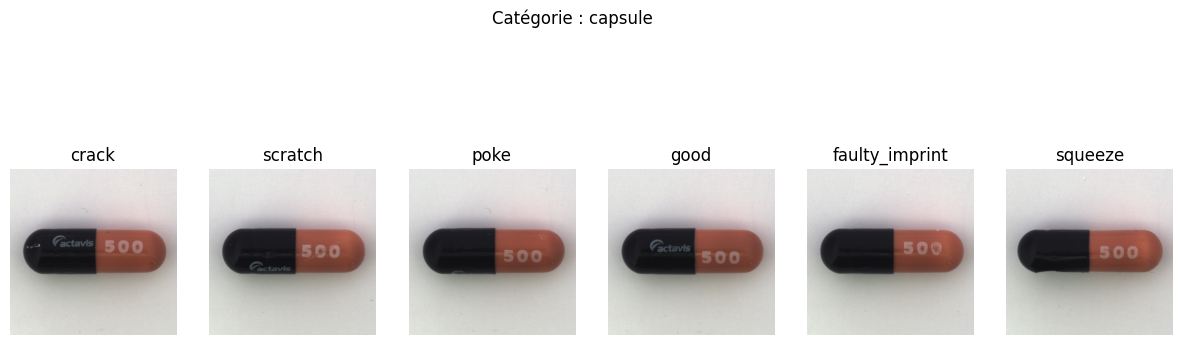

Catégorie : hazelnut
  MSE moyenne pour l'anomalie crack : 247.64
  MSE moyenne pour l'anomalie print : 514.72
  MSE moyenne pour l'anomalie good : 202.17
  MSE moyenne pour l'anomalie cut : 238.68
  MSE moyenne pour l'anomalie hole : 212.20


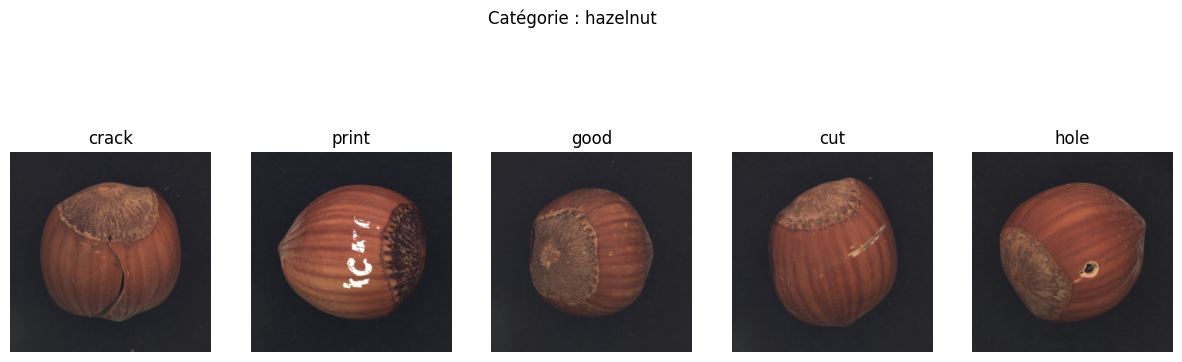

Catégorie : engine_wiring
  MSE moyenne pour l'anomalie fastening : 3335.79
  MSE moyenne pour l'anomalie multiple : 5061.35
  MSE moyenne pour l'anomalie cardboard : 21525.07
  MSE moyenne pour l'anomalie blue_hoop : 3884.03
  MSE moyenne pour l'anomalie good : 3452.24
  MSE moyenne pour l'anomalie obstruction : 5172.66


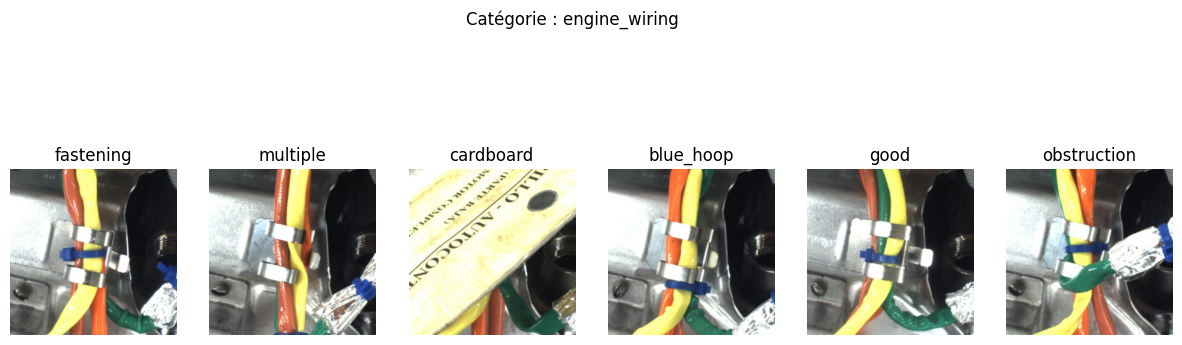

Catégorie : toothbrush
  MSE moyenne pour l'anomalie defective : 421.52
  MSE moyenne pour l'anomalie good : 213.50


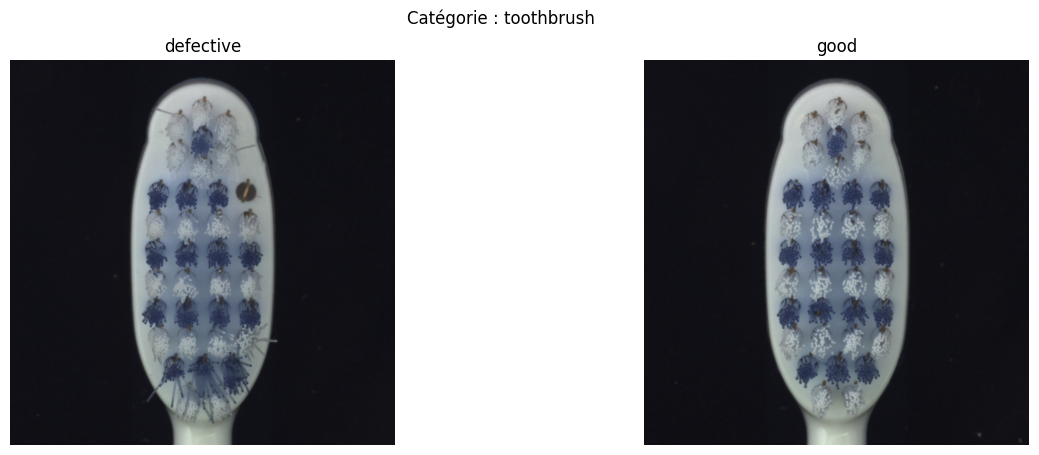

Catégorie : bottle
  MSE moyenne pour l'anomalie broken_small : 391.09
  MSE moyenne pour l'anomalie broken_large : 436.08
  MSE moyenne pour l'anomalie good : 242.99
  MSE moyenne pour l'anomalie contamination : 545.82


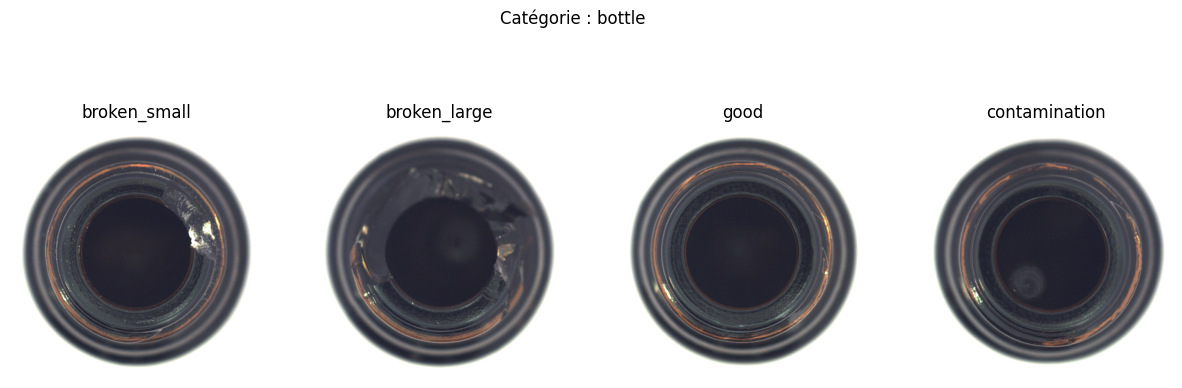

In [12]:
display_anomalies("data/")

# 

On ne capture surement pas assez les details fins \
Architecture plus sensible --> Unet avec des filtres de taille plus petite --> 3x3
Adapter la taille des mask en fonction des catégories : toothbrush et capsule --> petits \
                                                        bottle --> moyens \
                                                        engine et hazelnuth --> plus grand ou ne pas les changer étants donnés les résultats actuels \
Pour les catégories complexes (toothbrush, capsule, bottle) --> abaisser le learning rate 

# Architecture Unet et adaptation des pretext aux catégories

## Architecture Unet

In [ ]:
def double_conv(in_channels, out_channels):
    # returns a block compsed of two Convolution layers with ReLU activation function
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU()
    )   

class DownSampleBlock(nn.Module):

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv_block = double_conv(in_channels, out_channels)
        self.maxpool = nn.MaxPool2d(2) 

    def forward(self, x):
        x_skip = self.conv_block(x)
        x = self.maxpool(x_skip)

        return x , x_skip

class UpSampleBlock(nn.Module):

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv_block = double_conv(in_channels, out_channels)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

    def forward(self, x, x_skip):
        x = self.upsample(x)
        x = torch.cat([x, x_skip], dim=1)
        x = self.conv_block(x)
        
        return x
    

class UNet(nn.Module):

    def __init__(self, in_channels=3, out_channels=3):
        super().__init__()
                
        self.downsample_block_1 = DownSampleBlock(in_channels, 64)
        self.downsample_block_2 = DownSampleBlock(64, 128)
        self.middle_conv_block = double_conv(128, 256)        

            
        self.upsample_block_2 = UpSampleBlock(128 + 256, 128)
        self.upsample_block_1 = UpSampleBlock(128 + 64, 64)
        
        self.last_conv = nn.Conv2d(64, out_channels, 1)
        
        
    def forward(self, x):
        x, x_skip1 = self.downsample_block_1(x)
        x, x_skip2 = self.downsample_block_2(x)
        
        x = self.middle_conv_block(x)
        
        x = self.upsample_block_2(x, x_skip2) 
        x = self.upsample_block_1(x, x_skip1)
        
        out = self.last_conv(x)
        
        return out

## Pretext

In [ ]:
class ColorizationModel(nn.Module):
    def __init__(self):
        super(ColorizationModel, self).__init__()
        self.Model = UNet()

    def forward(self, x):
        grayscale_x = transforms.Grayscale()(x)  # Convert RGB to Grayscale
        x_hat = self.Model(grayscale_x)
        return x_hat, grayscale_x



class InpaintingModel(nn.Module):
    def __init__(self, mask_size=8):
        super(InpaintingModel, self).__init__()
        self.Model = UNet()
        self.mask_size = mask_size
    
    def apply_mask(self, x):
        masked_x = x.clone()

        for i in range(masked_x.size(0)):
            ul_x = np.random.randint(0, x.size(2) - self.mask_size + 1)
            ul_y = np.random.randint(0, x.size(3) - self.mask_size + 1)
            masked_x[i, :, ul_x:ul_x+self.mask_size, ul_y:ul_y+self.mask_size] = 0

        return masked_x
    
    def forward(self, x):
        x_masked = self.apply_mask(x)
        x_hat = self.Model(x_masked)
        return x_hat, x_masked
    

    

class MaskedAutoencoderModel(nn.Module):
    def __init__(self, mask_ratio=1/16):
        super(MaskedAutoencoderModel, self).__init__()
        self.Model = UNet()
        self.mask_ratio = mask_ratio
    
    def apply_mask(self, x):
        x_masked = x.clone()
        mask = torch.rand_like(x[:, 0, :, :]) < self.mask_ratio
        mask = mask.unsqueeze(1).repeat(1, x.size(1), 1, 1)
        x_masked[mask] = 0
        return x_masked
    
    def forward(self, x):
        x_masked = self.apply_mask(x)
        x_hat = self.Model(x_masked)
        return x_hat, x_masked

## Pipeline d'entraînement et d'évaluation

In [ ]:
def run_pipeline_multiple_pretexts(data_loaders_dict, pretexts=["colorization", "inpainting", "maskedautoencoder"], 
                                   num_epochs=10, lr=1e-3, device=device):
    results = {}

    for category in data_loaders_dict.keys():
        print(f"=== Entraînement pour la catégorie {category} ===")
        category_results = {}

        for pretext in pretexts:
            print(f"Entraînement pour le prétexte : {pretext}")

            # Créer le modèle et définir la perte
            if pretext == "colorization":
                model = ColorizationModel(latent_dim=latent_dim)
                criterion = nn.MSELoss()
            elif pretext == "inpainting":
                model = InpaintingModel(latent_dim=latent_dim)
                criterion = nn.MSELoss()
            elif pretext == "maskedautoencoder":
                model = MaskedAutoencoderModel(latent_dim=latent_dim)
                criterion = nn.MSELoss()

            optimizer = optim.Adam(model.parameters(), lr=lr)

            # Entraîner le modèle
            train_loader = data_loaders_dict[category]["train_loader"]
            test_loader = data_loaders_dict[category]["test_loader"]
            train_ssl_model(model, train_loader, test_loader, criterion, optimizer, 
                                       device=device, epochs=num_epochs)
            
            # Sauvegarder le modèle
            model_path = f"{category}_{pretext}_model.pth"
            torch.save(model.state_dict(), model_path)
            print(f"Modèle sauvegardé : {model_path}")

            # Évaluer le modèle
            print(f"=== Évaluation pour le prétexte {pretext} - Catégorie {category} ===")
            roc_auc = evaluate_ssl_model(model, test_loader, pretext=pretext, device=device)

            # Stocker les résultats
            category_results[pretext] = {"model": model, "roc_auc": roc_auc}

        results[category] = category_results

    return results

# Test convolution attentionnelle

In [50]:
# Define CutPaste augmentations
class CutPaste:
    def __init__(self, variant="normal"):
        self.variant = variant

    def __call__(self, img):
        w, h = img.size
        cut_w, cut_h = np.random.randint(w // 8, w // 4), np.random.randint(h // 8, h // 4)
        x, y = np.random.randint(0, w - cut_w), np.random.randint(0, h - cut_h)
        patch = img.crop((x, y, x + cut_w, y + cut_h))
        paste_x, paste_y = np.random.randint(0, w - cut_w), np.random.randint(0, h - cut_h)

        if self.variant == "scar":
            patch = patch.resize((cut_w // 2, cut_h * 2))

        img.paste(patch, (paste_x, paste_y))
        return img

In [78]:
mean = pixel_stats["toothbrush"]["mean"]
std = pixel_stats["toothbrush"]["std"]


train_transforms = transforms.Compose([
    CutPaste(variant="normal"),  # Augmentation CutPaste
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)  # Normalisation
])

test_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

In [79]:
class CategoryDataset(Dataset):
    def __init__(self, root_dir, transform=None, mode="train"):
        self.root_dir = os.path.join(root_dir, mode)
        self.image_paths = []
        self.labels = []  # 0 = normal, 1 = anomalie

        self.transform = transform

        if mode == "train":
            normal_dir = os.path.join(self.root_dir, "good")
            self.image_paths += [os.path.join(normal_dir, f) for f in os.listdir(normal_dir)]
            self.labels += [0] * len(self.image_paths)
        elif mode == "test":
            for defect_type in os.listdir(self.root_dir):
                defect_dir = os.path.join(self.root_dir, defect_type)
                self.image_paths += [os.path.join(defect_dir, f) for f in os.listdir(defect_dir)]
                self.labels += [0 if defect_type == "good" else 1] * len(os.listdir(defect_dir))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

In [80]:
# Chargement des datasets
train_dataset = CategoryDataset(
    root_dir="data/toothbrush",
    transform=train_transforms,
    mode="train"
)

test_dataset = CategoryDataset(
    root_dir="data/toothbrush",
    transform=test_transforms,
    mode="test"
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.06540787..1.2362145].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.06540787..1.2676256].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.077851176..1.3681412].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.08407289..1.3744233].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.077851176..1.3241656].


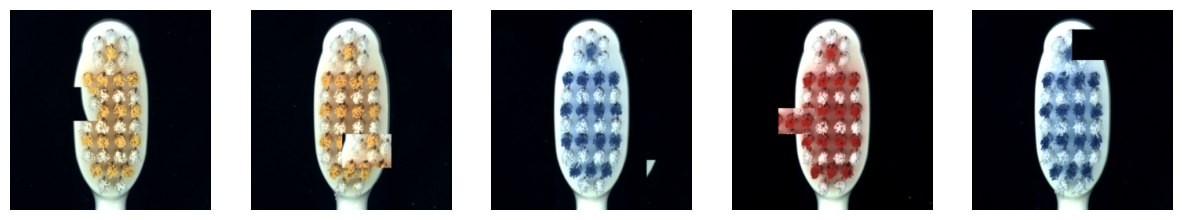

In [81]:
# Exemple de visualisation
examples, _ = next(iter(train_loader))
examples = examples.permute(0, 2, 3, 1)  # Reformatage pour matplotlib
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i in range(5):
    axes[i].imshow(examples[i].numpy() * 0.5 + 0.5)  # Dé-normalisation
    axes[i].axis("off")
plt.show()

In [95]:
class Attention(nn.Module):
    def __init__(self, dim, heads=8, dim_head=64, dropout=0.):
        super().__init__()
        inner_dim = dim_head * heads
        project_out = not (heads == 1 and dim_head == dim)

        self.heads = heads
        self.scale = dim_head ** -0.5

        self.attend = nn.Softmax(dim=-1)
        self.dropout = nn.Dropout(dropout)

        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias=False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x):
        qkv = self.to_qkv(x).chunk(3, dim=-1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h=self.heads), qkv)

        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale

        attn = self.attend(dots)
        attn = self.dropout(attn)

        out = torch.matmul(attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)


class ChannelWiseTransformerBlock(nn.Module):
    def __init__(self, num_patches, patch_dim=1, dim=64, heads=5, dim_head=64, dropout=0.):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(patch_dim)
        self.projection = nn.Linear(patch_dim ** 2, dim)
        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches, dim))

        self.mha = Attention(dim, heads=heads, dim_head=dim_head, dropout=dropout)
        self.sigmoid = nn.Sigmoid()

    def forward(self, z):
        x = self.avg_pool(z)
        x = x.flatten(-2)

        x = self.projection(x)
        x += self.pos_embedding

        x = self.mha(x)
        x = x.mean(-1).unsqueeze(-1).unsqueeze(-1)
        x = self.sigmoid(x)

        return z * x

# Define SSPCAB block
class SSPCAB(nn.Module):
    def __init__(self, channels, kernel_dim=1, dilation=1):
        super(SSPCAB, self).__init__()
        self.pad = kernel_dim + dilation
        self.border_input = kernel_dim + 2 * dilation + 1

        self.relu = nn.ReLU()
        self.transformer = ChannelWiseTransformerBlock(num_patches=channels, patch_dim=1)

        self.conv1 = nn.Conv2d(channels, channels, kernel_dim)
        self.conv2 = nn.Conv2d(channels, channels, kernel_dim)
        self.conv3 = nn.Conv2d(channels, channels, kernel_dim)
        self.conv4 = nn.Conv2d(channels, channels, kernel_dim)

    def forward(self, x_in):
        x = F.pad(x_in, (self.pad, self.pad, self.pad, self.pad), "constant", 0)

        x1 = self.conv1(x[:, :, :-self.border_input, :-self.border_input])
        x2 = self.conv2(x[:, :, self.border_input:, :-self.border_input])
        x3 = self.conv3(x[:, :, :-self.border_input, self.border_input:])
        x4 = self.conv4(x[:, :, self.border_input:, self.border_input:])
        x = self.relu(x1 + x2 + x3 + x4)

        x = self.transformer(x)

        # Calcul de la reconstruction erreur par image
        sspcab_loss = torch.mean((x - x_in) ** 2, dim=(1, 2, 3))
        return x, sspcab_loss  # Output and reconstruction loss

# Define the full model
class AnomalyDetectionModel(nn.Module):
    def __init__(self, in_channels):
        super(AnomalyDetectionModel, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.sspcab = SSPCAB(128, kernel_dim=1, dilation=1)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(64, in_channels, kernel_size=2, stride=2)
        )

    def forward(self, x):
        x_chap = self.encoder(x)
        x_chap, sspcab_loss = self.sspcab(x_chap)
        x_chap = self.decoder(x_chap)
        loss = torch.mean((x - x_chap) ** 2, dim=(1, 2, 3)) + sspcab_loss
        return x, loss

# Training function
def train(model, dataloader, optimizer, device):
    model.train()
    total_loss = 0

    for imgs, _ in dataloader:
        imgs = imgs.to(device)
        optimizer.zero_grad()

        recon, losses = model(imgs)
        loss = losses.mean()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

def evaluate(model, dataloader, device):
    model.eval()
    anomaly_scores = []
    labels = []

    with torch.no_grad():
        for imgs, lbls in dataloader:
            imgs = imgs.to(device)
            outputs, losses = model(imgs)
            print(losses)
            loss = nn.MSELoss(outputs, images)  # Perte par pixel
            per_image_loss = loss.mean(dim=(1, 2, 3))  # Moyenne spatiale pour chaque image

            anomaly_scores.extend(per_image_loss.cpu().numpy())
            labels.extend(lbls.numpy())  # Transforme les labels en liste plate

    return np.array(anomaly_scores), np.array(labels)

# Plot ROC curve
def plot_roc(labels, scores):
    fpr, tpr, _ = roc_curve(labels, scores)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

In [83]:
model = AnomalyDetectionModel(in_channels=3).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
epochs = 10

# Assuming data_loaders_dict contains dataloaders as in the provided code
#train_loader = data_loaders_dict['toothbrush']['train_loader']
#test_loader = data_loaders_dict['toothbrush']['test_loader']

for epoch in range(epochs):
    train_loss = train(model, train_loader, optimizer, device)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {train_loss:.4f}")

Epoch 1/10, Loss: 0.9137
Epoch 2/10, Loss: 0.9003
Epoch 3/10, Loss: 0.8936
Epoch 4/10, Loss: 0.8846
Epoch 5/10, Loss: 0.8778
Epoch 6/10, Loss: 0.8671
Epoch 7/10, Loss: 0.8622
Epoch 8/10, Loss: 0.8553
Epoch 9/10, Loss: 0.8496
Epoch 10/10, Loss: 0.8433


In [96]:
scores, labels = evaluate(model, test_loader, device)
print(f"Scores shape: {scores.shape}, Labels shape: {labels.shape}")

tensor(0.8294)


RuntimeError: Boolean value of Tensor with more than one value is ambiguous

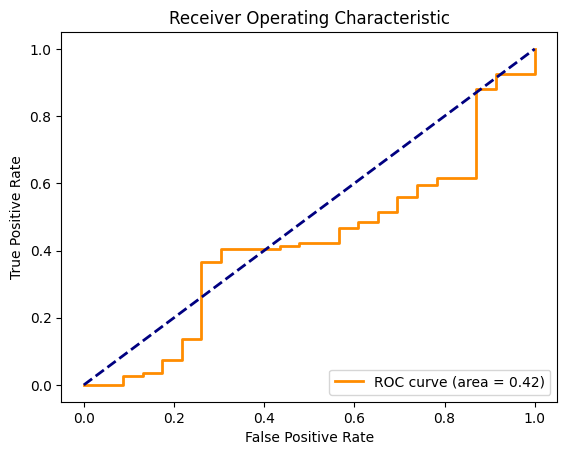

In [75]:
plot_roc(labels, scores)